In [ ]:
import os

# Set Kaggle configuration directory
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

# Rename the Kaggle API key file to the expected name
!mv '/content/kaggle (2).json' '/content/kaggle.json'

# Ensure the Kaggle API key has the correct permissions
!chmod 600 '/content/kaggle.json'

# Verify the changes
!ls '/content'

kaggle.json  sample_data


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation


 98% 699M/714M [00:02<00:00, 318MB/s]
100% 714M/714M [00:02<00:00, 279MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
import os
from glob import glob
import pandas as pd
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [ ]:
data_path = "/content/lgg-mri-segmentation/kaggle_3m"
df = create_df(data_path)
train_df, val_df, test_df = split_df(df)


In [ ]:
train_df.iloc[1]

images_paths    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
masks_paths     /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...
Name: 3359, dtype: object

In [ ]:
print('Train\t', train_df.shape, '\nVal\t', val_df.shape, '\nTest\t', test_df.shape)

Train	 (3143, 2) 
Val	 (393, 2) 
Test	 (393, 2)


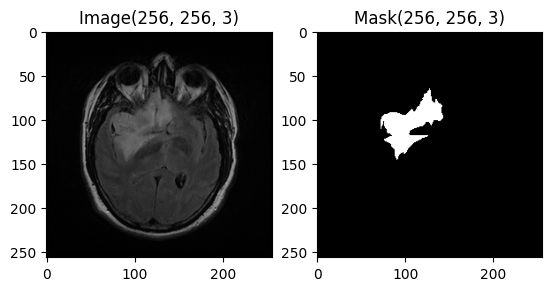

In [ ]:
image = cv2.imread(train_df.iloc[0, 0]) / 255.0
mask = cv2.imread(train_df.iloc[0, 1]) / 255.0
mask = np.where(mask>=0.5, 1., 0.)

plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Image'+str(image.shape))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Mask'+str(mask.shape))
plt.show()

In [ ]:
df.head()

,images_paths,masks_paths
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...


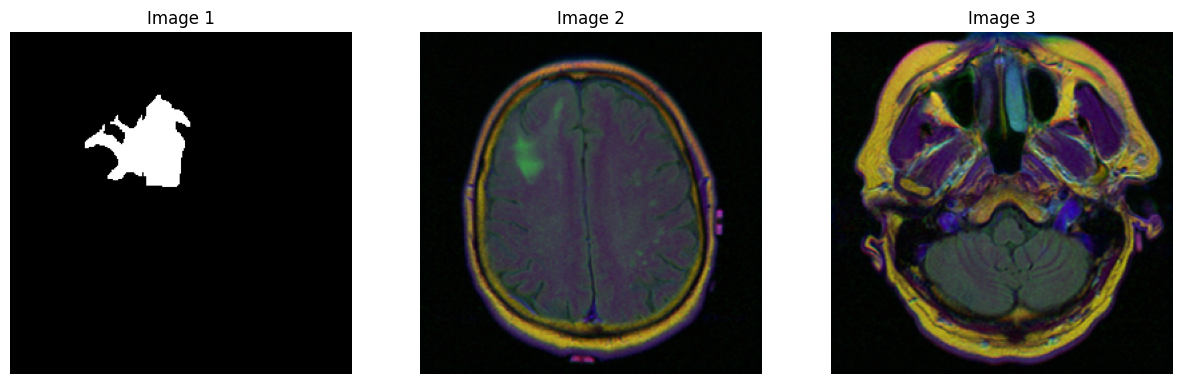

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from random import sample

def load_images_from_folder(folder, num_samples=3):
    file_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    selected_files = sample(file_list, min(num_samples, len(file_list)))
    images = []

    for file_name in selected_files:
        img_path = os.path.join(folder, file_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB
        images.append(img)

    return images

# Example usage
data_path = "/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909"
sample_images = load_images_from_folder(data_path)

# Display the images
plt.figure(figsize=(15, 5))
for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Image {i + 1}")
    plt.axis("off")

plt.show()


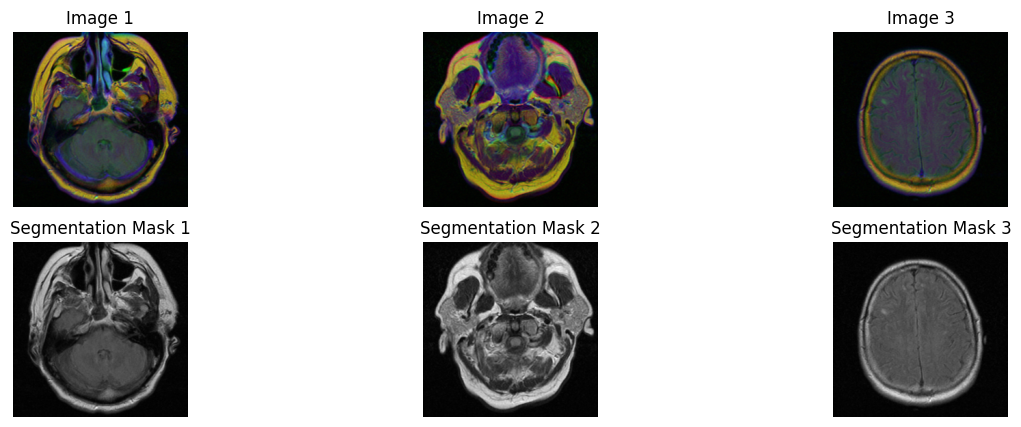

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from random import sample

def load_images_and_masks(image_folder, mask_folder, num_samples=3):
    image_file_list = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    selected_files = sample(image_file_list, min(num_samples, len(image_file_list)))
    images = []
    masks = []

    for file_name in selected_files:
        # Load the image
        img_path = os.path.join(image_folder, file_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load the segmentation mask
        mask_path = os.path.join(mask_folder, file_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        images.append(img)
        masks.append(mask)

    return images, masks

# Example usage
image_folder = "/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909"
mask_folder = "/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909"
sample_images, sample_masks = load_images_and_masks(image_folder, mask_folder)

# Display the images and segmentation masks side by side
plt.figure(figsize=(15, 5))
for i in range(len(sample_images)):
    plt.subplot(2, len(sample_images), i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Image {i + 1}")
    plt.axis("off")

    plt.subplot(2, len(sample_images), len(sample_images) + i + 1)
    plt.imshow(sample_masks[i], cmap='gray')
    plt.title(f"Segmentation Mask {i + 1}")
    plt.axis("off")

plt.show()


In [ ]:
class Brain_mri_dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe  ,  transform = None ,  mask_transform= None):
        self.df = dataframe #pd.read_csv(annotations_file)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):
        image = cv2.imread(self.df.iloc[idx, 0]) / 255.0
        mask = cv2.imread(self.df.iloc[idx, 1])  / 255.0
        mask = np.where(mask>=0.5, 1., 0.)
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [ ]:
transform_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_data = Brain_mri_dataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = Brain_mri_dataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = Brain_mri_dataset(test_df, transform = transform_ ,  mask_transform= transform_)

batch_size = 64

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)

In [ ]:
print('Training batches\t', len(train_dataloader))
print('Validation batches\t', len(val_dataloader))
print('Test batches\t\t', len(test_dataloader))

Training batches	 50
Validation batches	 7
Test batches		 7


In [ ]:
img_sample, msk_sample = next(iter(val_dataloader))
print(img_sample.shape, '\t', img_sample.dtype)
print(msk_sample.shape, '\t', msk_sample.dtype)

torch.Size([64, 3, 256, 256]) 	 torch.float64
torch.Size([64, 3, 256, 256]) 	 torch.float64


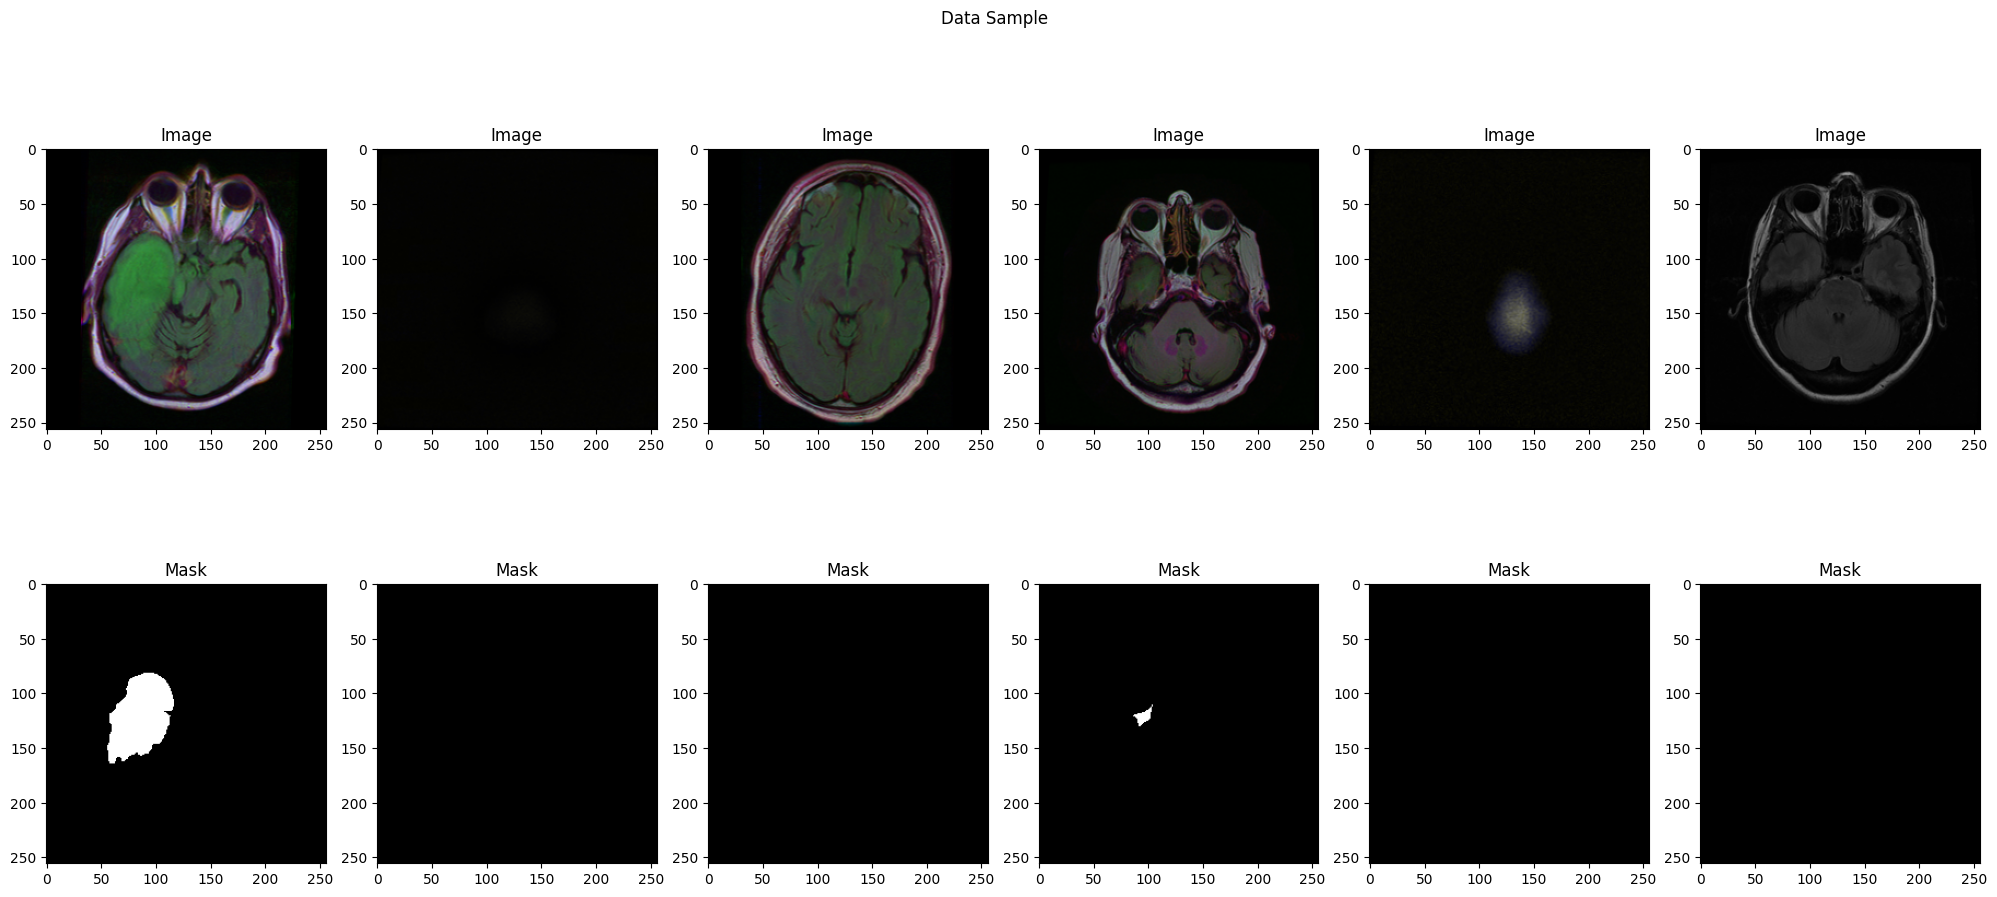

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i in range(6):
  axs[0, i].imshow(img_sample[i].permute(1,2,0))
  axs[0, i].set_title("Image")

  axs[1, i].imshow(msk_sample[i].permute(1,2,0))
  axs[1, i].set_title("Mask")
fig.suptitle('Data Sample')
fig.tight_layout()
fig.show()

In [ ]:
class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__()

       # Encoder
       self.encoder1 = nn.Sequential(
           nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True),
           nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True)
       )
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder2 = nn.Sequential(
           nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True)
       )
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder3 = nn.Sequential(
           nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True)
       )
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder4 = nn.Sequential(
           nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True)
       )
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


       # Bottleneck
       self.bottleneck = nn.Sequential(
           nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
       )

       # Decoder
       self.upconv4 = nn.Sequential(
           nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder4 = nn.Sequential(
           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh(),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh()
       )
       self.upconv3 = nn.Sequential(
           nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder3 = nn.Sequential(
           nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv2 = nn.Sequential(
           nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder2 = nn.Sequential(
           nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv1 = nn.Sequential(
           nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder1 = nn.Sequential(
           nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.conv = nn.Sequential(
           nn.ConvTranspose2d(32, 3, kernel_size=(1, 1), stride=(1, 1)),
           nn.Sigmoid()
           )

   def forward(self, x):
        #Encoder
       encoder1 = self.encoder1(x)
       encoder2 = self.encoder2(self.pool1(encoder1))
       encoder3 = self.encoder3(self.pool2(encoder2))
       encoder4 = self.encoder4(self.pool3(encoder3))

       # Bottleneck
       bottleneck = self.bottleneck(self.pool4(encoder4))

       #Decoder & Connections
       x = self.upconv4(bottleneck)
      #  print(encoder4.shape); print(x.shape);
       x = torch.cat([x, encoder4], dim=1)
      #  print(x.shape);
       x = self.decoder4(x)
      #  print(x.shape);

       x = self.upconv3(x)
       x = torch.cat([x, encoder3], dim=1)
       x = self.decoder3(x)
      #  print(x.shape);

       x = self.upconv2(x)
       x = torch.cat([x, encoder2], dim=1)
       x = self.decoder2(x)
      #  print(x.shape);


       x = self.upconv1(x)
       x = torch.cat([x, encoder1], dim=1)
       x = self.decoder1(x)
      #  print(x.shape);

       x = self.conv(x)
      #  print(x.shape);

       return x #(x >= 0.6).float()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



device(type='cuda')

In [ ]:
model = UNet().to(device)
model

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 7765603
Trainable parameters: 7765603


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 100
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2).sum()

        return 1 - ((2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth))

In [ ]:
def IOU(y_true, y_pred, smooth=100):
    intersection = (y_true * y_pred).sum()
    sum = (y_true + y_pred).sum()
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [ ]:
learning_rate = 0.01

criterion = DiceLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

In [ ]:
epochs = 10

train_loss = []
val_loss = []
train_IOU = []
val_IOU = []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0
    total_train_IOU = 0.0
    total_val_IOU = 0.0

    # Training mode
    model.train()

    for img, label in train_dataloader:
        img, label = img.to(device).float(), label.to(device).float()
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, label)
        total_train_loss += loss.item()
        IOU_value = IOU(label, pred)
        total_train_IOU += IOU_value.item()
        loss.backward()
        optimizer.step()

    train_loss.append(total_train_loss / len(train_dataloader))
    train_IOU.append(total_train_IOU / len(train_dataloader))

    # Validation mode
    model.eval()

    with torch.no_grad():
        for image, label in val_dataloader:
            image, label = image.to(device).float(), label.to(device).float()
            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()
            IOU_value = IOU(label, pred)
            total_val_IOU += IOU_value.item()

    val_loss.append(total_val_loss / len(val_dataloader))
    val_IOU.append(total_val_IOU / len(val_dataloader))

    print('Epoch: {}/{}, Train Loss: {:.4f}, Train IOU: {:.4f}, Val Loss: {:.4f}, Val IOU: {:.4f}'.format(
        epoch + 1, epochs, train_loss[-1], train_IOU[-1], val_loss[-1], val_IOU[-1]
    ))



Epoch: 1/10, Train Loss: 0.9735, Train IOU: 0.0431, Val Loss: 0.9734, Val IOU: 0.1160
Epoch: 2/10, Train Loss: 0.9727, Train IOU: 0.0776, Val Loss: 0.9743, Val IOU: 0.1200
Epoch: 3/10, Train Loss: 0.9726, Train IOU: 0.0834, Val Loss: 0.9737, Val IOU: 0.0673
Epoch: 4/10, Train Loss: 0.9725, Train IOU: 0.0881, Val Loss: 0.9722, Val IOU: 0.1039
Epoch: 5/10, Train Loss: 0.9727, Train IOU: 0.0950, Val Loss: 0.9739, Val IOU: 0.2080
Epoch: 6/10, Train Loss: 0.9723, Train IOU: 0.0939, Val Loss: 0.9736, Val IOU: 0.0866
Epoch: 7/10, Train Loss: 0.9721, Train IOU: 0.1041, Val Loss: 0.9705, Val IOU: 0.1550
Epoch: 8/10, Train Loss: 0.9718, Train IOU: 0.1277, Val Loss: 0.9679, Val IOU: 0.1225
Epoch: 9/10, Train Loss: 0.9719, Train IOU: 0.1256, Val Loss: 0.9739, Val IOU: 0.1763
Epoch: 10/10, Train Loss: 0.9715, Train IOU: 0.1551, Val Loss: 0.9732, Val IOU: 0.2293


In [ ]:
def show_sample(data,n=2):
  imgs, true_masks = data
  results = model(imgs.to(device).float()).cpu()
  results = torch.where(results >= 0.6, 1.0, 0.0)
#   results = torch.tensor(results)

  fig, axs = plt.subplots(3, n, figsize=(n*3, 9))
  for i in range(n):
      axs[0, i].imshow(imgs[i].permute(1,2,0))
      axs[0, i].set_title("Input Image")

      axs[1, i].imshow(results[i].permute(1,2,0))
      axs[1, i].set_title("Predected Mask")

      axs[2, i].imshow(true_masks[i].permute(1,2,0))
      axs[2, i].set_title("True Mask")
  fig.suptitle('Results Sample')
  fig.tight_layout()
  fig.show()

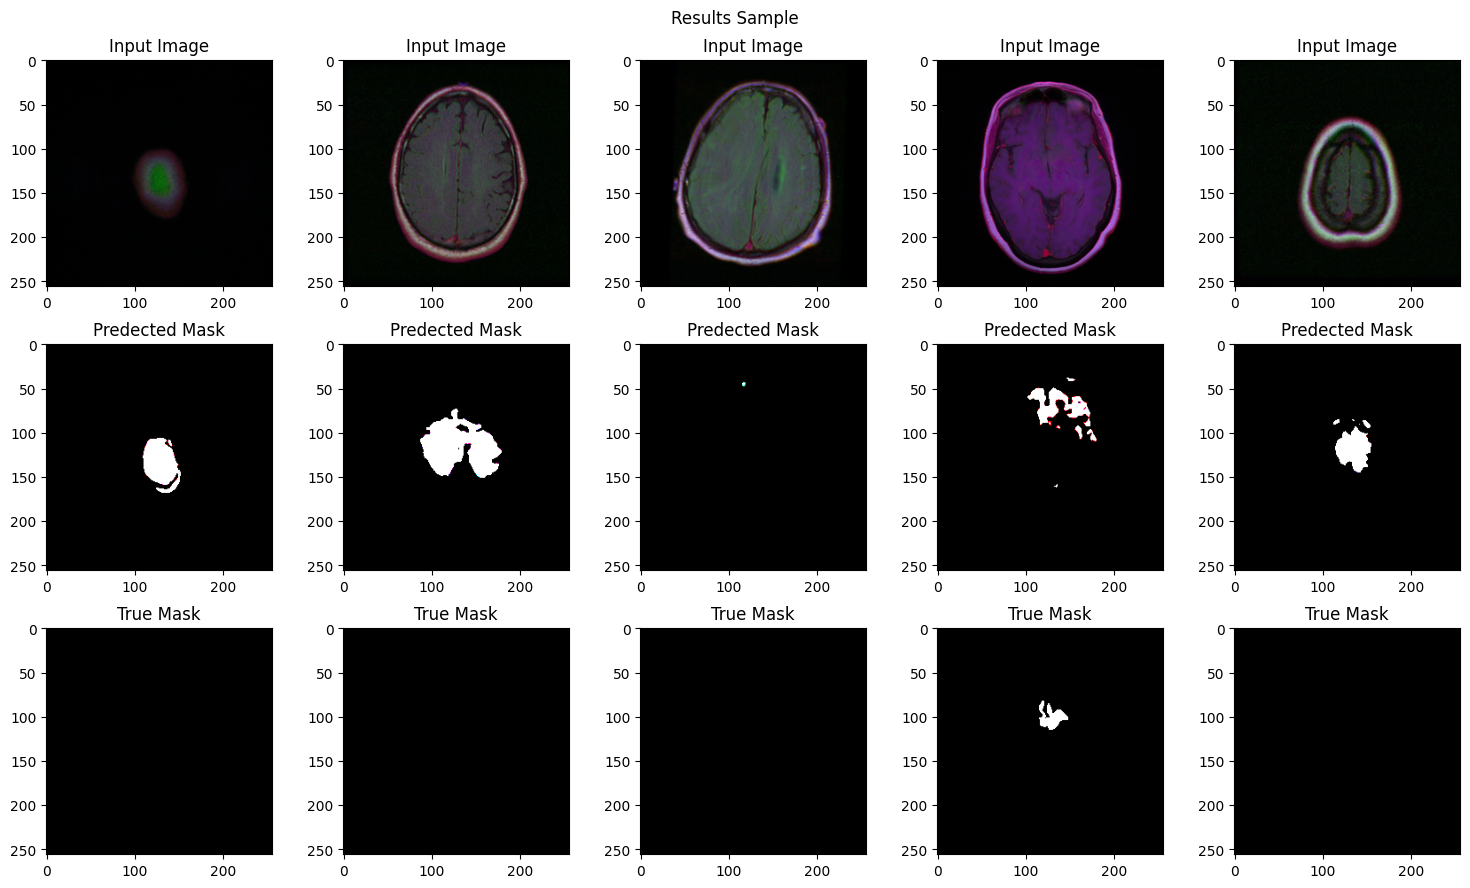

In [ ]:
show_sample(next(iter(test_dataloader)), 5)

In [ ]:
torch.save(model, 'unet_model.pth')



In [ ]:
loaded_model = torch.load('unet_model.pth')


In [ ]:
torch.save(model.state_dict(), 'unet_model_state_dict.pth') # Save only the model state dictionary (recommended)
loaded_model_state_dict = UNet()
loaded_model_state_dict.load_state_dict(torch.load('unet_model_state_dict.pth'))


<All keys matched successfully>

In [ ]:
model = UNet()
model.load_state_dict(torch.load('unet_model_state_dict.pth'))
model = model.to(device)

In [ ]:
from torchsummary import summary

# Assuming your model is already defined and named 'model'
model = UNet().to(device)
summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,928
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=b5b87c5697c0c6e07f9d8d9a4f7659f5b3c0ecd3836a19915089db1e85d54cc0
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

# Assuming your model is already defined and named 'model'
model = UNet().to(device)

# Create a dummy input
dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Generate a graph of the model
graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the graph as a PNG file
graph.render("unet_architecture", format="png", cleanup=True)


'unet_architecture.png'